---
title: Bounding Euler's Constant
date: 2024-08-12
---

I've been struggling with defining the transcendental functions like exp, sine, cosine in knuckledragger, my python proof assistant based around z3.

I think there's kind of a neat way to define exponentials and hence sines and cosines axiomatically by sneakily avoiding actual calculus notions and using more algebraic properties.

Exponentials are very special because they relate multiplication and addition

In [ ]:
import knuckledragger as kd
import z3
exp = z3.Function("exp", kd.R, kd.R)

x,y,z = z3.Reals('x y z')

exp_add = kd.axiom(z3.ForAll([x, y], exp(x + y) == exp(x) * exp(y)))

The addition property is a very powerful one, maybe suspiciously powerful. What _really_ gives us the right to say that a function should exist? This is the facts behind the slide rule, which I always thought of as kind of crazy. If someone tells you about such a function in 1530, do you believe them? Not every property or functional equation is actually satisfiable.

Ok ok ok, but I'm totally irrevocably exp-pilled, so we can move on.

This axiom is true of all powers though. What makes $e^x$ special?

I think what makes exp special is that $y' = y$. This is a calculus notion and difficult and inelegant to express directly in Z3 so far as I know. I'm working on it.

There is a related statement though that is easy to express. We can lower bound exponential by the linear approximation $1 + x$. After all, aren't linear approximations what differentiation is really about? 

In [ ]:
exp_lower = kd.axiom(z3.ForAll([x], exp(x) >= 1 + x)) # tight low approximation at x = 0.

This tangent is tight at $x=0$

The simple form of this may be because $e^x$ is convex and has a subderivative https://en.wikipedia.org/wiki/Subderivative .

We can take a look with numpy. It is wise to numerically sanity check any axioms. I may build facilities to make this easier.

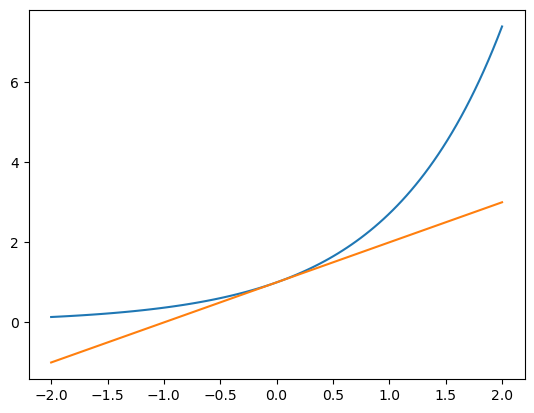

In [3]:
import numpy as np
import matplotlib.pyplot as plt
xs = np.linspace(-2,2,100)
plt.plot(xs, np.exp(xs), legend="e^x")
plt.plot(xs, 1 + xs)

From these definitions we can derive many other properties

In [79]:
exp_pos1 = kd.lemma(kd.QForAll([x], x > -1, exp(x) > 0), by=[exp_lower])
exp_pos = kd.axiom(z3.ForAll([x], exp(x) > 0)) # maybe we can derive this one?. We can range reduce anything to the range x > -1. Might require a bit of induction.

exp_zero = kd.lemma(z3.ForAll([x], exp(0) == 1), by=[exp_add, exp_pos])
# or in longer form
# exp(0) = exp(0 + 0) = exp(0) * exp(0) ===> 1 = 1 * 1 or 0 = 0 * 0
c = kd.Calc([], exp(0))
c.eq(exp(0) * exp(0), by=[exp_add])
_1 = kd.lemma(z3.Or(exp(0) == 0, exp(0) == 1), by=[c.qed()])
exp_zero = kd.lemma(exp(0) == 1, by=[_1, exp_pos1])

exp_div = kd.lemma(z3.ForAll([x, y], exp(x)*exp(-x) == 1), by=[exp_add, exp_zero])
exp_nzero = kd.lemma(z3.ForAll([x], exp(x) != 0), by=[exp_div])
exp_inv = kd.lemma(z3.ForAll([x], exp(-x) == 1/exp(x)), by=[exp_div])

# definition of euler's constant
e = kd.define("e", [], exp(1))

It enables us to also convert the lower bound into an upper bound in an interesting way.

There can't be a global polynomial upper bound to exponential. There can't even be a local tight polynomial upper bound to exponential.

But an interesting trick is that there is a rational upper bound we can derive from the previous facts. This is perhaps related to Pade approximation.

In [ ]:
exp_inv_lower = kd.lemma(z3.ForAll([x], exp(-x) >= 1 - x), by=[exp_lower])
exp_upper = kd.lemma(z3.ForAll([x], exp(-x) * exp(x) >= (1-x) * exp(x)), by=[exp_inv_lower, exp_pos])
exp_upper = kd.lemma(z3.ForAll([x], (1 -x) * exp(x) <= 1), by=[exp_upper, exp_div])

# showing off the .ge function of Calc chaining
c = kd.Calc([x], 1)
c.eq(exp(x) * exp(-x), by=[exp_div])
c.ge((1 - x) * exp(x), by=[exp_inv_lower, exp_pos])
c.qed()

What we've done is bent $e^x$ by multiplying by a polynomial factor and now we have a function

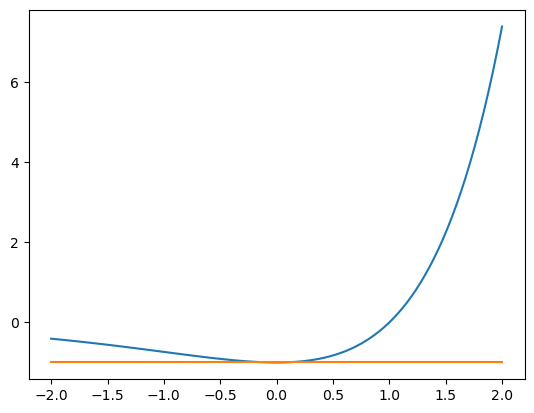

In [14]:
xs = np.linspace(-2,2,100)
plt.plot(xs, (xs - 1) * np.exp(xs))
plt.plot(xs, -np.ones(100))

By restricting the range we can avoid a divide by zero

In [18]:
# This fails because we miss the divide by zero precondition
exp_upper = kd.lemma(kd.QForAll([x], exp(x) <= 1/(1 - x)), by=[exp_upper])

LemmaError: (ForAll(x, exp(x) <= 1/(1 - x)), [|- ForAll(x, Implies(x < 1, exp(x) <= 1/(1 - x)))], 'Countermodel', [knuckledragger_goal = True,
 by_0 = True,
 exp = [1 -> 1/2, else -> 1/(1 + -1*Var(0))],
 /0 = [else -> 0]])

In [19]:
# this succeeds.
exp_upper = kd.lemma(kd.QForAll([x], x < 1, exp(x) <= 1/(1 - x)), by=[exp_upper])


We can visualize these two curves and see that 1/(1-x) does indeed lie above exp for a while and is tight at `x=0`.

/tmp/ipykernel_13083/2815046670.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xs, 1/(1 - xs))


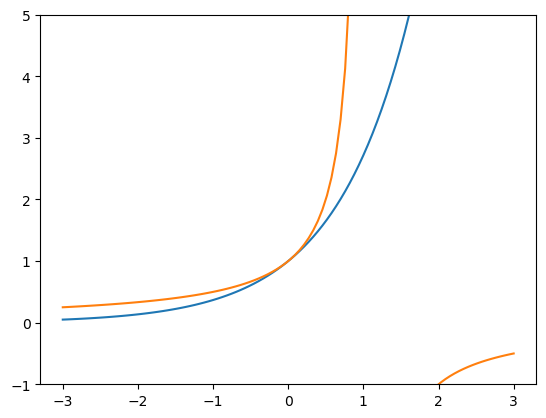

In [8]:
xs = np.linspace(-3,3,100)
plt.ylim(-1,5)
plt.plot(xs, np.exp(xs))
plt.plot(xs, 1/(1 - xs))

We can also establish rigorous bounds on $e$. How do computers actually calculate $e^x$? A common paradigm for many special functions is to perform range reduction using some identity to a small interval say `[-1,1]` and then use a calculable approximation such as a taylor series. We have the pieces to do that.

See https://people.cs.rutgers.edu/~sn349/rlibm/

In [49]:
# The most basic lower bound to e
kd.lemma(e() >= 2, by=[exp_lower, e.defn])

# a slightly tighter lower bound
c = kd.Calc([], exp(1))
c.eq(exp(0.5)*exp(0.5), by=[exp_add])
c.ge((1 + 0.5) * (1 + 0.5), by=[exp_lower])
c.qed()

# Or we can do this splitting generically.

c = kd.Calc([x], exp(x), assume=[x >= -2])
c.eq(exp(x/2)*exp(x/2), by=[exp_add])
c.ge((1 + x/2)*(1 + x/2), by=[exp_lower])
c.eq(1 + x + x**2 / 4)
exp_lower2 = c.qed()
exp_lower2

|- ForAll(x, Implies(x >= -2, exp(x) >= 1 + x + x**2/4))

It's interesting that `x >= -2` is required as an assumption to apply the inequalities. This is because when we have negatives around, inequalities get flipped. This is not the loosest requirement. We can see the actual intersection point is somewhere between -2 and -3.

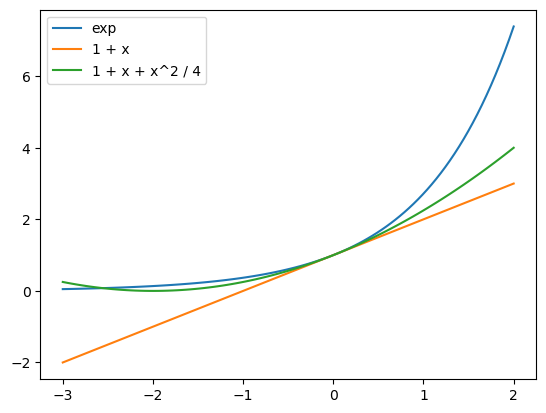

In [44]:
import numpy as np
import matplotlib.pyplot as plt
xs = np.linspace(-3,2,100)
plt.plot(xs, np.exp(xs), label="exp")
plt.plot(xs, 1 + xs, label="1 + x")
plt.plot(xs, 1 + xs +  xs**2 / 4, label="1 + x + x^2 / 4")
plt.legend()

We can use this new approximation in the same way as before to get a rigorous upper bound on $e$.

In [64]:
exp_inv_lower2 = kd.lemma(kd.QForAll([x], x <= 2, exp(-x) >= 1 - x + x**2/4), by=[exp_lower2])

c = kd.Calc([x], 1, assume=[x <= 2])
c.eq(exp(-x) * exp(x), by=[exp_div])
c.ge((1 - x + x**2/4) * exp(x), by=[exp_inv_lower2, exp_pos])
exp_upper = c.qed()

e_upper = kd.lemma(e() <= 1 / (1 - 1 + 1**2 / 4), by=[exp_upper, e.defn])
e_upper


|- e <= 4

I hope your mind is totally blown by this incredible upper bound.

Of course, I'm also willing to just accept an upper bound I know is true, or make an axiom schema out of a flint computation, but the games are good.

In [65]:
euler_approx = kd.axiom(z3.And(2.7 < e(), e() < 2.8))
exp_approx = kd.axiom(z3.ForAll([x], z3.And(2.7 ** x <= exp(x), exp(x) <= 2.8**x)))

# Bits and Bobbles
Getting the direction of `<=` and appropriate regions right is tricky. I would have made mistakes without machine assistance.

This is kind of a nice pattern to algebrize calculus ntions. Actually work with the linear approximations. Do not discuss derivatives which require more ocmplex notions.

f(x) >= f(a) + b * (x - a), x bounded or not. x not being bounded is nice

Multiplying both sides by the apppropriate polynomials is a nice way to reverse the directions of the inequalites at the appropriate spots.
`x sin(x) <= x**2`
`cos(x) >= 1 - x**2 / 2`

cvc5 has sine and cosine built in, but not with that much proving power.

With powers (sqrt, cube root, etc), cosine, sine, ln, polynomials and rationals, we've kind of got a lot of the pieces of what is discussed in basic calculus started.

Really all of this is closer in spririt to the manner pre-calc and calculus are taught than the standard real analysis approach.


A trivial sounding challenge problem for a proof assistant is defining cosine. We learn about cosine somewhere in grade school. How hard could it be?

I remember being a bit confused what the square root or cosine was.  Despite studying and manipulating these things for years, I did not know how to compute their digits by hand. I don't think this confusion is wrong.

Well, if you don't overthink it, maybe it is trivial. But I overthought it.

There is a game to play where we forget that we believe all the myriad facts we've leanred over the years and play the role of a disbelieving antagonist.

This isn't a totally aimless thought game because we are seeking a workable definition that can be understood by Z3. This is a mix of arbitrary and meaningful. SMTLIB is not a random theory. It has grown as more or less a collection of logical theories that we have effective algorithms to deal with. This is not the design goal of smtlib but it is a natural result of the evolutionary forces of its growth. SMTLib can handle linear equalities (gaussian elimination), inequalities (linear programming), uninterpreted functions (congruence closure), polynomials (grobner bases and polynomial normalization). This is a pretty reasonable list of unobjectionable stuff.

That is a more platonic thing.

## Geometric

The cosine and sine are first taught as trigonometry, [SOHCAHTOA](https://en.wikipedia.org/wiki/Mnemonics_in_trigonometry#SOH-CAH-TOA) and all that. They are the ratio of sides of right triangles or relatedly coordinates of positions on the unit circle.

There is a narrow definition of geometry that talks about construction by compass and straightedge. In this world, the general concept of sine of an arbitrary angle is hard to define. 

### Defining "angle"

The concept of angle seems slippery to me. Angles are things formed by the intersection of two lines. We get 4 angles there, 2 big, 2 small (is that true in all geometries? Not sure.). We can define an arbitrary number to the angle that is formed by a full circle of rotation (360 or 1 or $2\pi$ or $\tau$). Or the angle of a straight line (180 or 1/2 or $\pi$ or $\frac{\tau}{2}$)

I think I do acknowledge that one can concatenate angles.

## Infinite Series
I think the "simplest" "definition" is to remember the taylor series

$\cos(x) = 1 -\frac{x^2}{2} + \frac{x^4}{4!} - ... = \sum_{i=0}^\inf \frac{(-x)^{2n}}{n!}$

This is not without it's issues. How do we define an infinite sum? There are many possible options. The most typical is to say that this is the limit of partial sums as the upper end ends up arbitrarily close to infinity

This is insanity? Right? We teach cosine and sine to 9th graders don't we? They don't know about infinite sums.

I find it interesting to consider my own education. I was taught some kind of styandard curriculum, but at an age where I didn't care that much and had no contextabout the manner and style I was being taught. The exact details of my bootstrapping are now lost in murky memory.


## Oscillation and Differential Equation
At a certain point sine and cosine held their greatest meaning to me in the form of solutions to the motion of a [simple harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator).

Mathemtically, this is the solution to $y'' = -y$  or in two component for $y'=z, z'=-y$ which indeed looks like the rulers for differentiating $\sin$ and $\cos$ 

## Algebraic

Euler's formula is super powerful and once you know it, one feels that all other sine and cosine identities are subsumed by it.

https://en.wikipedia.org/wiki/Euler%27s_formula
$e^{i\theta} = \cos(\theta) + i\sin(\theta)$

It is easy to remember how to manipulate $e^x$ as it has simple rules.


### What is $e^x$?
It is taking the power of euler's constant

### What is euler's constant?
### What is power?
Power is an operation that makes sense for integer values of power.

$3^2 = 3 * 3 = 9$

It also can make sense sort of for rational values of power by clearing out

$ x^{\frac{n}{m}} = y \iff x^n = y^m $

Power doesn't necessarily make sense if the base is negative, or at least it gets more confusing. Then the result would be a complex number  $(-1)^{.5} = e^{i \pi}^.5 = e^{i \frac{\pi}{2} = i$.

Now we have grounded out at something we can easily talk about in Z3 kind of.


In [2]:
import cvc5.pythonic as cvc5

s = cvc5.Solver()
x,y = cvc5.Reals("x y")
s.add(cvc5.Not(cvc5.ForAll([x,y], 2**x * 2**y == 2**(x+y))))
s.check()

RuntimeError: The exponent of the POW(^) operator can only be a positive integral constant below 67108864. Exception occurred in:
  (^ 2.0 @quantifiers_skolemize_3)

In [21]:
#import os
#os.environ["KNUCKLE_SOLVE"] = "cvc5"
import knuckledragger as kd
import knuckledragger.smt as smt

x,y,z = smt.Reals('x y z')
pow2 = kd.define("pow2", [x], 2 ** x)
pow2_1 = kd.lemma(pow2(1) == 2, by=[pow2.defn])
pow2_0 = kd.lemma(pow2(0) == 1, by=[pow2.defn])
pow2_add = kd.lemma(smt.ForAll([x,y], pow2(x) * pow2(y) == pow2(x + y)), by=[pow2.defn], admit=True)

pow2_neg = kd.lemma(smt.ForAll([x], pow2(x) * pow2(-x) == 1), by=[pow2_add, pow2.defn])
#pow2_sub = kd.lemma(smt.ForAll([x,y], pow2(x) / pow2(y) == pow2(x - y)), by=[pow2_add, pow2_neg, pow2.defn])

pow2_succ = kd.lemma(smt.ForAll([x], pow2(x) * pow2(1) == pow2(x + 1)), by=[pow2_add])
pow2_succ_2 = kd.lemma(smt.ForAll([x], pow2(x) * 2 == pow2(x + 1)), by=[pow2_succ, pow2_1])


pow2_diff = kd.lemma(smt.ForAll([x,y], pow2(x + 1) - pow2(x) == pow2(x)), by=[pow2_succ_2])



Admitting lemma ForAll([x, y], pow2(x)*pow2(y) == pow2(x + y))


In [4]:

import os
os.environ["KNUCKLE_SOLVE"] = "cvc5"
import knuckledragger as kd
import knuckledragger.smt as smt

x,y,z = smt.Reals('x y z')
#exp = smt.Function("exp", kd.R, kd.R)
#
if smt.solver == "cvc5":
    exp = kd.define("exp", [x], smt.Expontential(x))
    e = kd.define("e", [], exp(1))
else:
    e = Function()

smt.prove(smtexp(1) >= 1)


counterexample
[exp = [else -> 0]]


Maybe this was too agressive a topic for one post.

